## Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [2]:
plt.style.use('seaborn-poster')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

## Load source datasets

In [3]:
train = pd.read_csv("../input/mh-wsmlc/train.csv")
print(f"train: {train.shape}")
train.head()

train: (175296, 18)


,Year,Month,Day,Hour,Minute,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,Temperature,Pressure,Relative Humidity,Solar Zenith Angle,Precipitable Water,Wind Direction,Wind Speed,Fill Flag
0,2009,1,1,0,0,0,0,0,0,0.0,5.0,1010,75.34,106.15,0.499,346.1,3.1,0
1,2009,1,1,0,30,0,0,0,0,1.0,5.0,1010,80.81,112.28,0.490,346.1,3.1,0
2,2009,1,1,1,0,0,0,0,4,0.0,5.0,1010,78.27,118.50,0.482,347.9,3.2,0
3,2009,1,1,1,30,0,0,0,4,0.0,4.0,1010,78.27,124.78,0.478,347.9,3.1,0
4,2009,1,1,2,0,0,0,0,4,0.0,4.0,1010,76.45,131.12,0.475,350.0,3.0,0


In [4]:
test = pd.read_csv("../input/mh-wsmlc/test.csv")
print(f"test: {test.shape}")
test.head()

test: (17520, 18)


,Year,Month,Day,Hour,Minute,Cloud Type,Dew Point,Temperature,Pressure,Relative Humidity,Solar Zenith Angle,Precipitable Water,Wind Direction,Wind Speed,Fill Flag,Clearsky DHI,Clearsky DNI,Clearsky GHI
0,2019,1,1,0,0,7,18.4,18.8,1008,97.70,106.23,3.5,190,2.3,0,NaN,NaN,NaN
1,2019,1,1,0,30,3,18.4,18.6,1008,98.92,112.36,3.5,187,2.5,0,NaN,NaN,NaN
2,2019,1,1,1,0,3,18.2,18.5,1008,98.35,118.58,3.5,184,2.8,0,NaN,NaN,NaN
3,2019,1,1,1,30,3,18.2,18.3,1008,99.58,124.86,3.5,185,3.0,0,NaN,NaN,NaN
4,2019,1,1,2,0,0,18.0,18.0,1008,99.71,131.20,3.6,186,3.1,0,NaN,NaN,NaN


## EDA

### Check for null and duplicate records

**Observation**

* No null values found in train dataset
* No null values found in test dataset (except the target columns)
* No duplicates found in train and test datasets

In [5]:
train.isnull().sum()

Year                  0
Month                 0
Day                   0
Hour                  0
Minute                0
Clearsky DHI          0
Clearsky DNI          0
Clearsky GHI          0
Cloud Type            0
Dew Point             0
Temperature           0
Pressure              0
Relative Humidity     0
Solar Zenith Angle    0
Precipitable Water    0
Wind Direction        0
Wind Speed            0
Fill Flag             0
dtype: int64

In [6]:
test.isnull().sum()

Year                      0
Month                     0
Day                       0
Hour                      0
Minute                    0
Cloud Type                0
Dew Point                 0
Temperature               0
Pressure                  0
Relative Humidity         0
Solar Zenith Angle        0
Precipitable Water        0
Wind Direction            0
Wind Speed                0
Fill Flag                 0
Clearsky DHI          17520
Clearsky DNI          17520
Clearsky GHI          17520
dtype: int64

In [7]:
dup = train[train.duplicated(subset=test.columns.tolist(), keep=False)]
print(f"Duplicate records in train: {dup.shape[0]}")

dup = test[test.duplicated(subset=test.columns.tolist(), keep=False)]
print(f"Duplicate records in test: {dup.shape[0]}")

Duplicate records in train: 0
Duplicate records in test: 0


### Check for data leakage

**Observation**

* No leakage (record present in both train and test) found

In [8]:
common_df = pd.merge(
    train,
    test,
    how='inner',
    on=test.columns.tolist()
)

print(f"Leakage records: {common_df.shape[0]}")
common_df.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1208: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


Leakage records: 0


,Year,Month,Day,Hour,Minute,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,Temperature,Pressure,Relative Humidity,Solar Zenith Angle,Precipitable Water,Wind Direction,Wind Speed,Fill Flag


In [9]:
train['Date'] = train.apply(lambda row: pd.to_datetime(str(row['Year']).split('.')[0] + \
                                                       str(row['Month']).split('.')[0].zfill(2) + \
                                                       str(row['Day']).split('.')[0].zfill(2), format='%Y%m%d'), axis=1)

train['Quarter'] = train['Date'].apply(lambda x: pd.to_datetime(x).quarter)
train['Week'] = train['Date'].apply(lambda x: pd.to_datetime(x).week)
train['DayofWeek'] = train['Date'].apply(lambda x: pd.to_datetime(x).dayofweek)
train['isWeekend'] = np.where(train['DayofWeek'].isin([5,6]),1,0)
train.head()

,Year,Month,Day,Hour,Minute,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,...,Solar Zenith Angle,Precipitable Water,Wind Direction,Wind Speed,Fill Flag,Date,Quarter,Week,DayofWeek,isWeekend
0,2009,1,1,0,0,0,0,0,0,0.0,...,106.15,0.499,346.1,3.1,0,2009-01-01,1,1,3,0
1,2009,1,1,0,30,0,0,0,0,1.0,...,112.28,0.490,346.1,3.1,0,2009-01-01,1,1,3,0
2,2009,1,1,1,0,0,0,0,4,0.0,...,118.50,0.482,347.9,3.2,0,2009-01-01,1,1,3,0
3,2009,1,1,1,30,0,0,0,4,0.0,...,124.78,0.478,347.9,3.1,0,2009-01-01,1,1,3,0
4,2009,1,1,2,0,0,0,0,4,0.0,...,131.12,0.475,350.0,3.0,0,2009-01-01,1,1,3,0


### Examine target

**Observation**

* All target variables are highly correlated in some way
* There's high linear correlation between (DHI and DNI) and (GHI and DNI)
* Both DNI and GHI values are 0, when DHI = 0
* When comparing raw GHI with calculated value (formula below), it's showing vibrating relationship

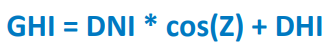

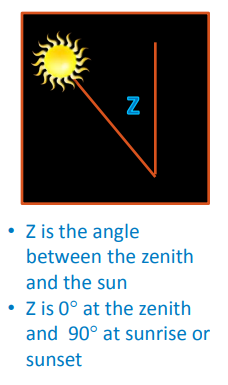

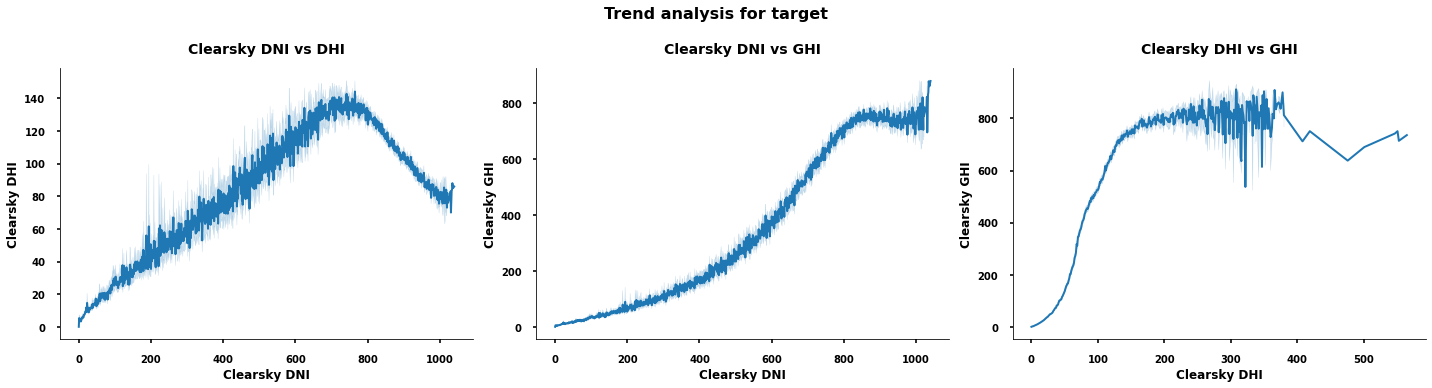

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.lineplot(x='Clearsky DNI', y='Clearsky DHI', data=train, ax=ax[0])
sns.lineplot(x='Clearsky DNI', y='Clearsky GHI', data=train, ax=ax[1])
sns.lineplot(x='Clearsky DHI', y='Clearsky GHI', data=train, ax=ax[2])
ax[0].set_title('Clearsky DNI vs DHI', pad=15)
ax[1].set_title('Clearsky DNI vs GHI', pad=15)
ax[2].set_title('Clearsky DHI vs GHI', pad=15)
fig.tight_layout()
plt.suptitle("Trend analysis for target",
             y=1.07, fontweight='bold');

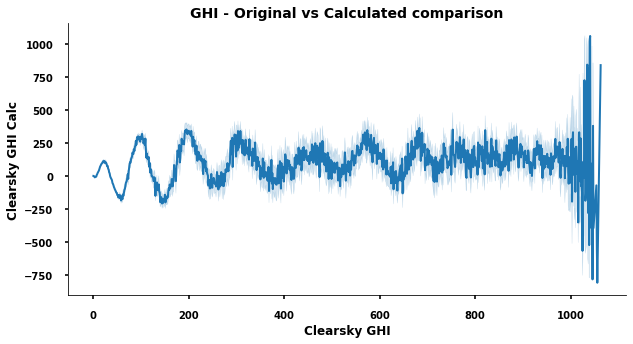

In [11]:
train['Clearsky GHI Calc'] = train['Clearsky DHI'] + (train['Clearsky DNI'] * np.cos(train['Solar Zenith Angle']))

plt.figure(figsize=(10, 5))
sns.lineplot(x='Clearsky GHI', y='Clearsky GHI Calc', data=train)
plt.title("GHI - Original vs Calculated comparison");

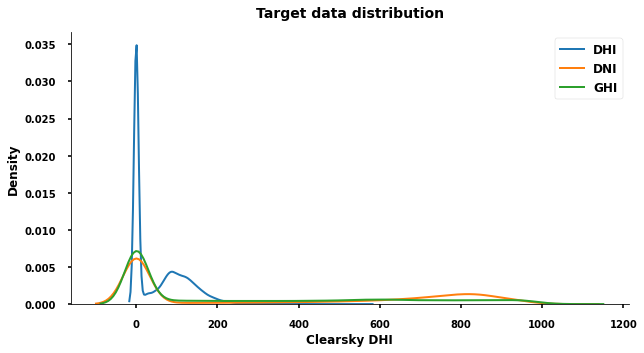

In [12]:
plt.figure(figsize=(10, 5))
sns.kdeplot(x='Clearsky DHI', data=train, label='DHI')
sns.kdeplot(x='Clearsky DNI', data=train, label='DNI')
sns.kdeplot(x='Clearsky GHI', data=train, label='GHI')
plt.legend()
plt.title("Target data distribution", pad=15);

In [13]:
train[train['Clearsky DHI']==0]['Clearsky DNI'].value_counts()

0    88248
Name: Clearsky DNI, dtype: int64

In [14]:
train[train['Clearsky DHI']==0]['Clearsky GHI'].value_counts()

0    88248
Name: Clearsky GHI, dtype: int64

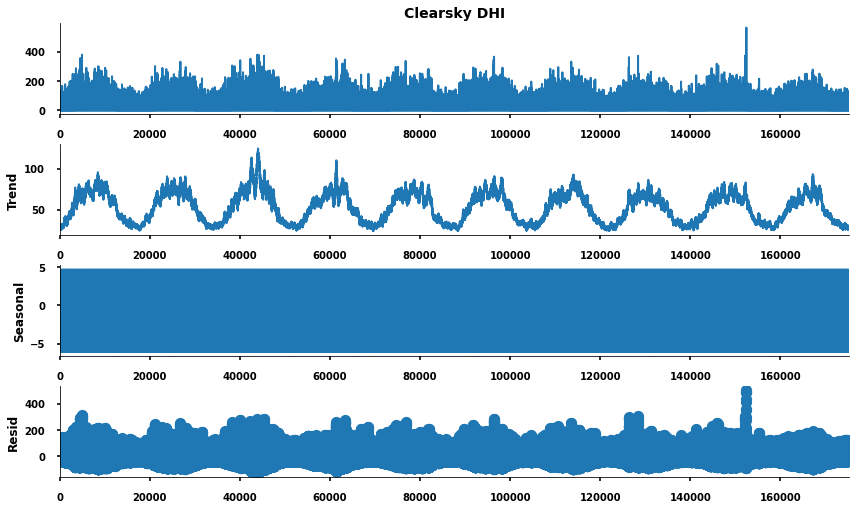

In [15]:
seas_d = sm.tsa.seasonal_decompose(train['Clearsky DHI'], model='add', period=365);
fig = seas_d.plot()
fig.set_figheight(7)
fig.set_figwidth(12);

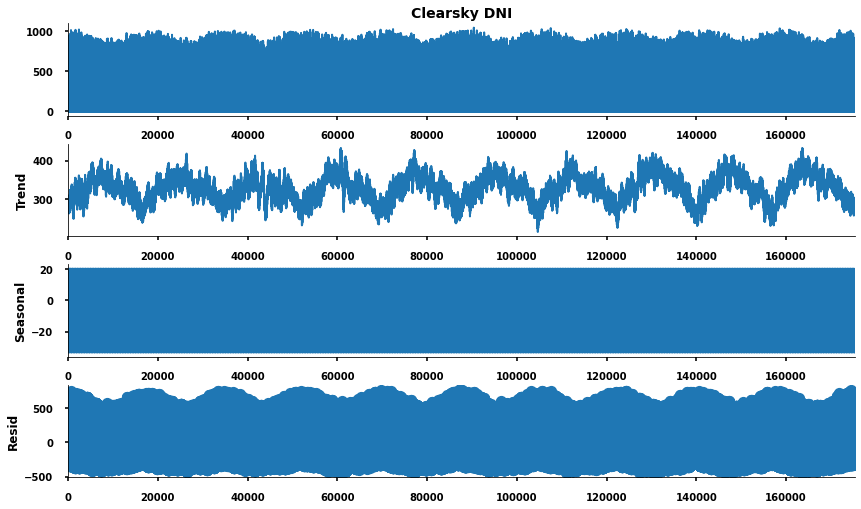

In [16]:
seas_d = sm.tsa.seasonal_decompose(train['Clearsky DNI'], model='add', period=365);
fig = seas_d.plot()
fig.set_figheight(7)
fig.set_figwidth(12);

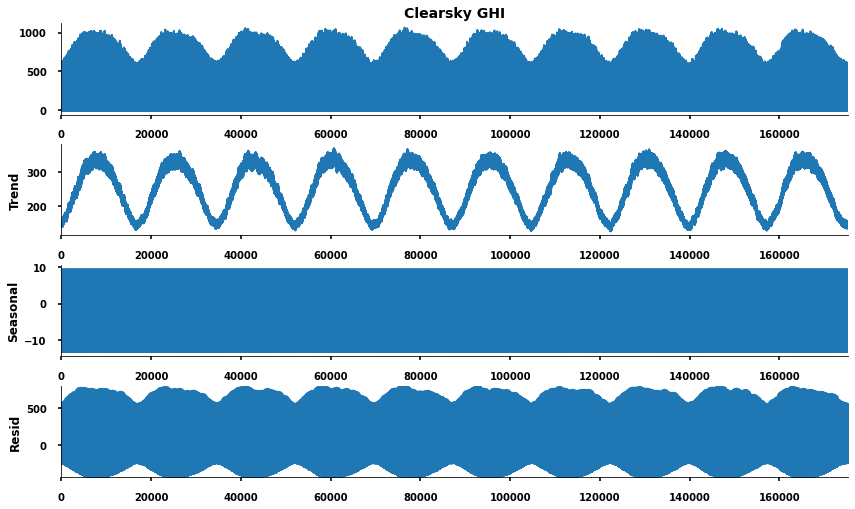

In [17]:
seas_d = sm.tsa.seasonal_decompose(train['Clearsky GHI'], model='add', period=365);
fig = seas_d.plot()
fig.set_figheight(7)
fig.set_figwidth(12);

In [18]:
def plot_corr(series):
    fig,ax = plt.subplots(2,1, figsize=(15, 6))
    fig = sm.tsa.graphics.plot_acf(series, lags=365, ax=ax[0])
    fig = sm.tsa.graphics.plot_pacf(series, lags=365, ax=ax[1])
    fig.tight_layout();

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


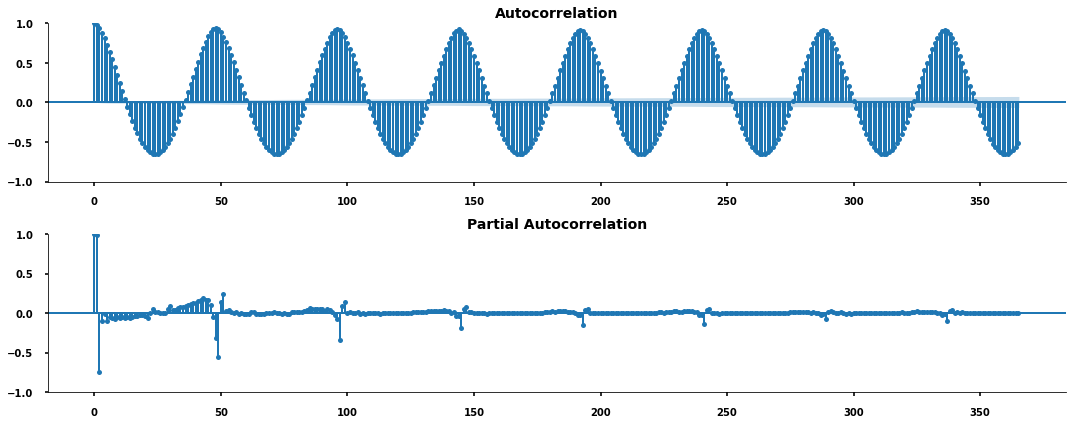

In [19]:
plot_corr(train['Clearsky DHI'])

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


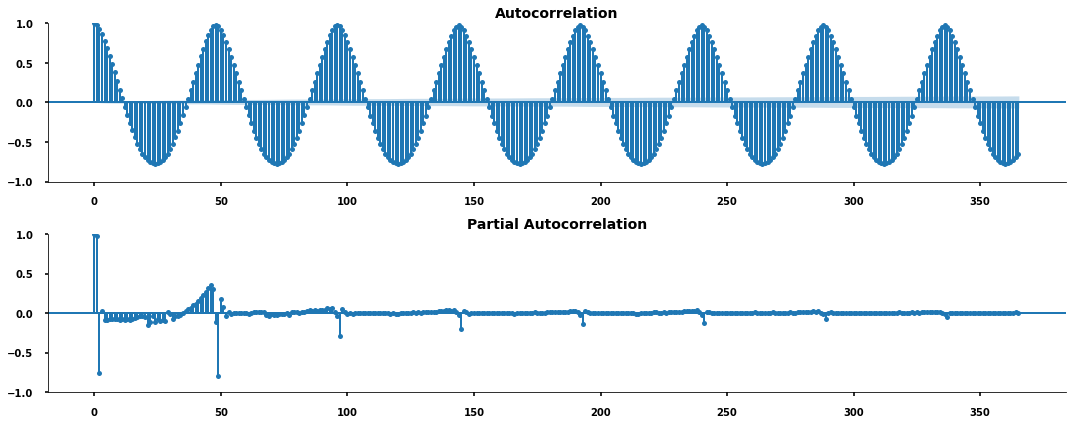

In [20]:
plot_corr(train['Clearsky DNI'])

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


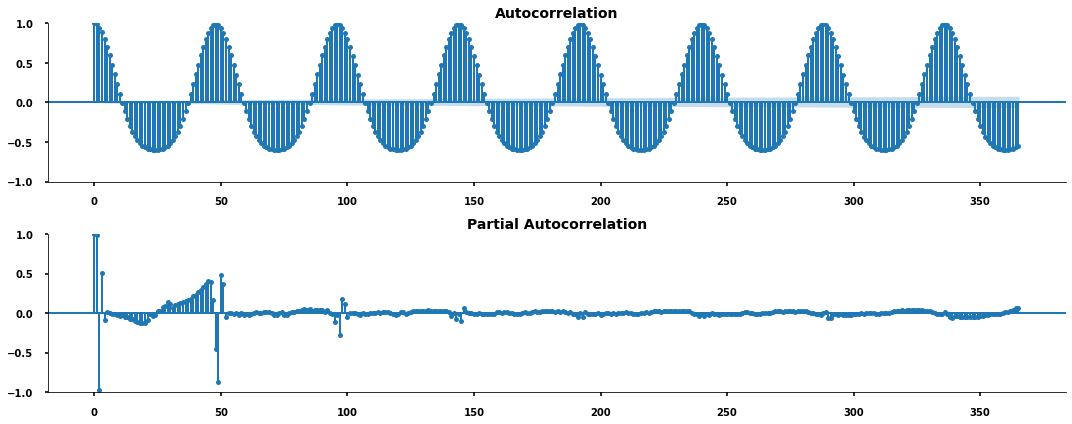

In [21]:
plot_corr(train['Clearsky GHI'])

### Year

**Observation**

* GHI and DNI are almost constant till 2017, and increases in 2018
* DHI is almost constant till 2016, and increases after 2017

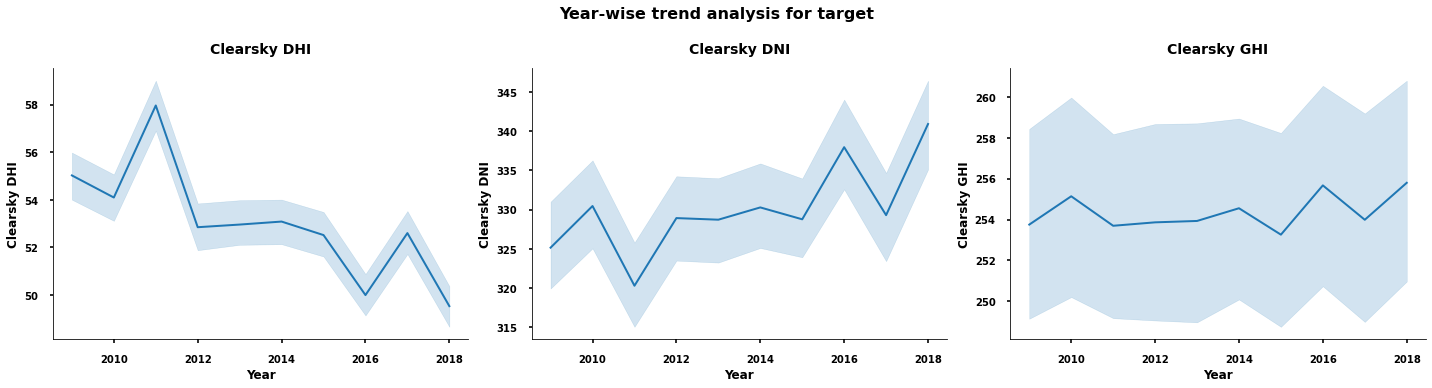

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.lineplot(x='Year', y='Clearsky DHI', data=train, ax=ax[0])
sns.lineplot(x='Year', y='Clearsky DNI', data=train, ax=ax[1])
sns.lineplot(x='Year', y='Clearsky GHI', data=train, ax=ax[2])
ax[0].set_title('Clearsky DHI', pad=15)
ax[1].set_title('Clearsky DNI', pad=15)
ax[2].set_title('Clearsky GHI', pad=15)
fig.tight_layout()
plt.suptitle("Year-wise trend analysis for target",
             y=1.07, fontweight='bold');

### Month

**Observation**

* All target variables are showing same relationship with month i.e. increasing till mid-year then decreasing

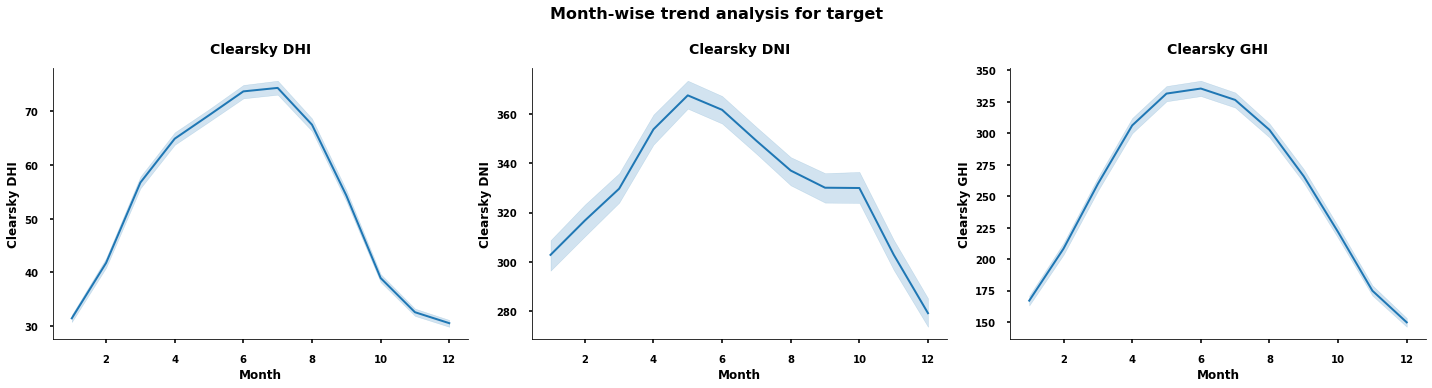

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.lineplot(x='Month', y='Clearsky DHI', data=train, ax=ax[0])
sns.lineplot(x='Month', y='Clearsky DNI', data=train, ax=ax[1])
sns.lineplot(x='Month', y='Clearsky GHI', data=train, ax=ax[2])
ax[0].set_title('Clearsky DHI', pad=15)
ax[1].set_title('Clearsky DNI', pad=15)
ax[2].set_title('Clearsky GHI', pad=15)
fig.tight_layout()
plt.suptitle("Month-wise trend analysis for target",
             y=1.07, fontweight='bold');

### Day

**Observation**

* All target variables are almost constant through-out a month

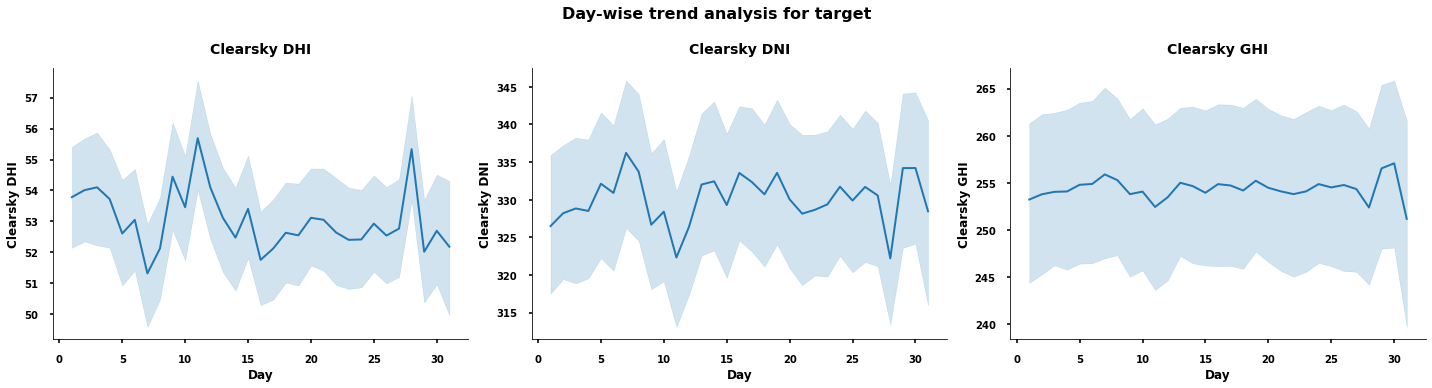

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.lineplot(x='Day', y='Clearsky DHI', data=train, ax=ax[0])
sns.lineplot(x='Day', y='Clearsky DNI', data=train, ax=ax[1])
sns.lineplot(x='Day', y='Clearsky GHI', data=train, ax=ax[2])
ax[0].set_title('Clearsky DHI', pad=15)
ax[1].set_title('Clearsky DNI', pad=15)
ax[2].set_title('Clearsky GHI', pad=15)
fig.tight_layout()
plt.suptitle("Day-wise trend analysis for target",
             y=1.07, fontweight='bold');

### Quarter

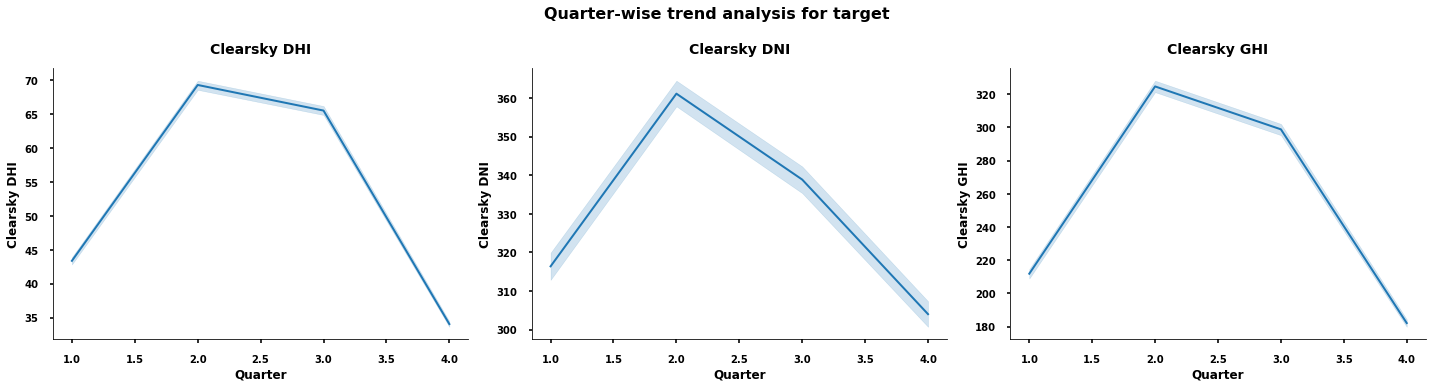

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.lineplot(x='Quarter', y='Clearsky DHI', data=train, ax=ax[0])
sns.lineplot(x='Quarter', y='Clearsky DNI', data=train, ax=ax[1])
sns.lineplot(x='Quarter', y='Clearsky GHI', data=train, ax=ax[2])
ax[0].set_title('Clearsky DHI', pad=15)
ax[1].set_title('Clearsky DNI', pad=15)
ax[2].set_title('Clearsky GHI', pad=15)
fig.tight_layout()
plt.suptitle("Quarter-wise trend analysis for target",
             y=1.07, fontweight='bold');

### Week

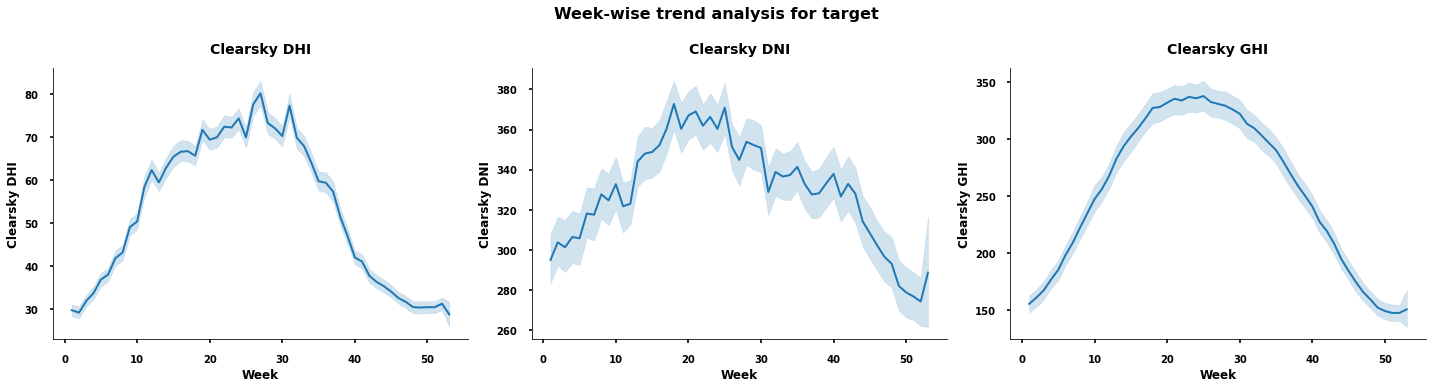

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.lineplot(x='Week', y='Clearsky DHI', data=train, ax=ax[0])
sns.lineplot(x='Week', y='Clearsky DNI', data=train, ax=ax[1])
sns.lineplot(x='Week', y='Clearsky GHI', data=train, ax=ax[2])
ax[0].set_title('Clearsky DHI', pad=15)
ax[1].set_title('Clearsky DNI', pad=15)
ax[2].set_title('Clearsky GHI', pad=15)
fig.tight_layout()
plt.suptitle("Week-wise trend analysis for target",
             y=1.07, fontweight='bold');

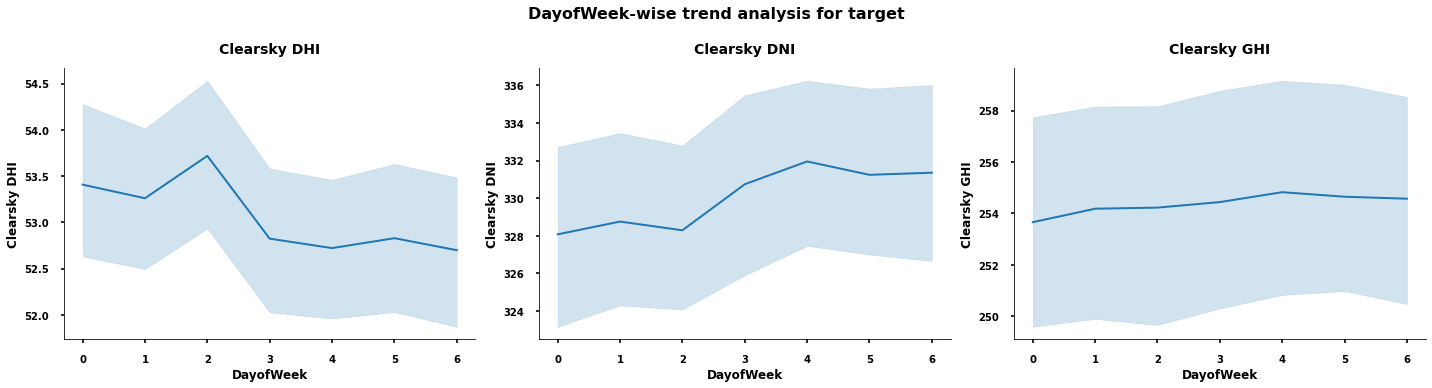

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.lineplot(x='DayofWeek', y='Clearsky DHI', data=train, ax=ax[0])
sns.lineplot(x='DayofWeek', y='Clearsky DNI', data=train, ax=ax[1])
sns.lineplot(x='DayofWeek', y='Clearsky GHI', data=train, ax=ax[2])
ax[0].set_title('Clearsky DHI', pad=15)
ax[1].set_title('Clearsky DNI', pad=15)
ax[2].set_title('Clearsky GHI', pad=15)
fig.tight_layout()
plt.suptitle("DayofWeek-wise trend analysis for target",
             y=1.07, fontweight='bold');

### Hour

**Observation**

* All target variables are 0 between 1AM to 9AM (just before sunrise)

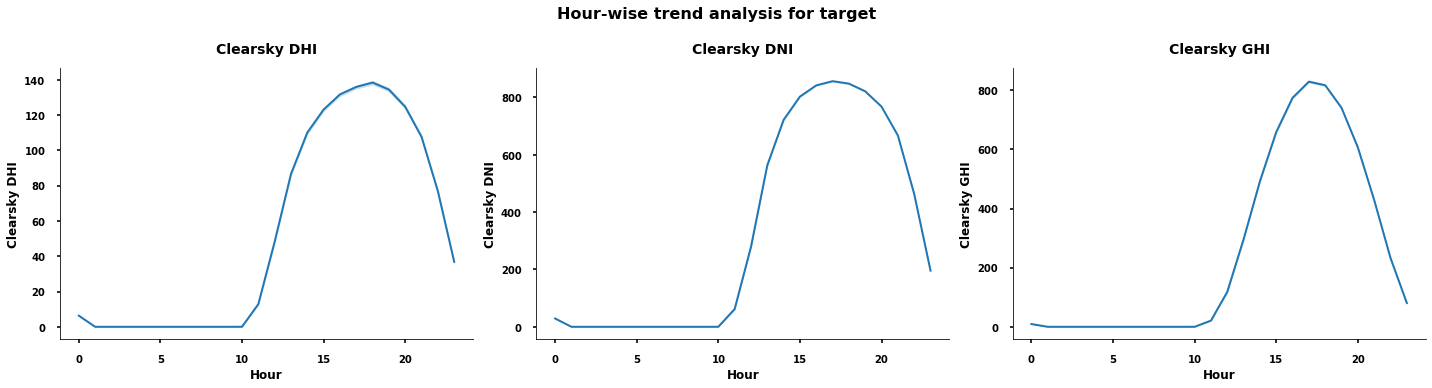

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.lineplot(x='Hour', y='Clearsky DHI', data=train, ax=ax[0])
sns.lineplot(x='Hour', y='Clearsky DNI', data=train, ax=ax[1])
sns.lineplot(x='Hour', y='Clearsky GHI', data=train, ax=ax[2])
ax[0].set_title('Clearsky DHI', pad=15)
ax[1].set_title('Clearsky DNI', pad=15)
ax[2].set_title('Clearsky GHI', pad=15)
fig.tight_layout()
plt.suptitle("Hour-wise trend analysis for target",
             y=1.07, fontweight='bold');

In [29]:
train[train['Hour'].isin([1,2,3,4,5,6,7,8,9])]['Clearsky DHI'].value_counts()

0    65736
Name: Clearsky DHI, dtype: int64

In [30]:
train[train['Hour'].isin([1,2,3,4,5,6,7,8,9])]['Clearsky DNI'].value_counts()

0    65736
Name: Clearsky DNI, dtype: int64

In [31]:
train[train['Hour'].isin([1,2,3,4,5,6,7,8,9])]['Clearsky GHI'].value_counts()

0    65736
Name: Clearsky GHI, dtype: int64

### Cloud Type

**Observation**

* Cloud type = 1 and 10, are missing in test dataset
* For cloud type = 10, only one record is present in train dataset (all target variables are zero)

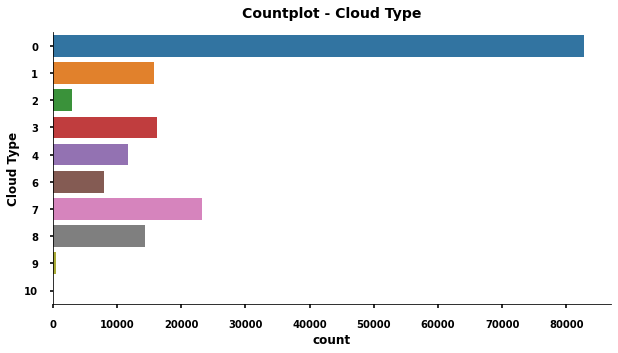

In [32]:
plt.figure(figsize=(10, 5))
sns.countplot(y='Cloud Type', data=train)
plt.title("Countplot - Cloud Type", pad=15);

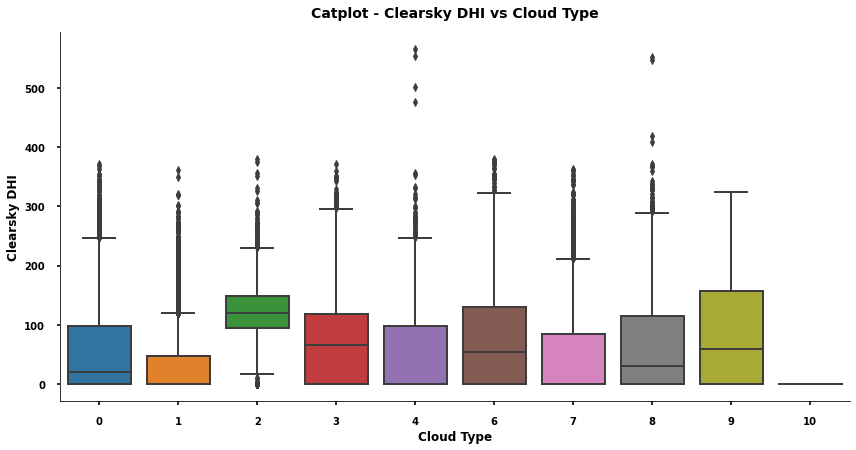

In [33]:
sns.catplot(y='Clearsky DHI', x='Cloud Type', kind="box", data=train, height=6, aspect=2)
plt.title('Catplot - Clearsky DHI vs Cloud Type', pad=15);

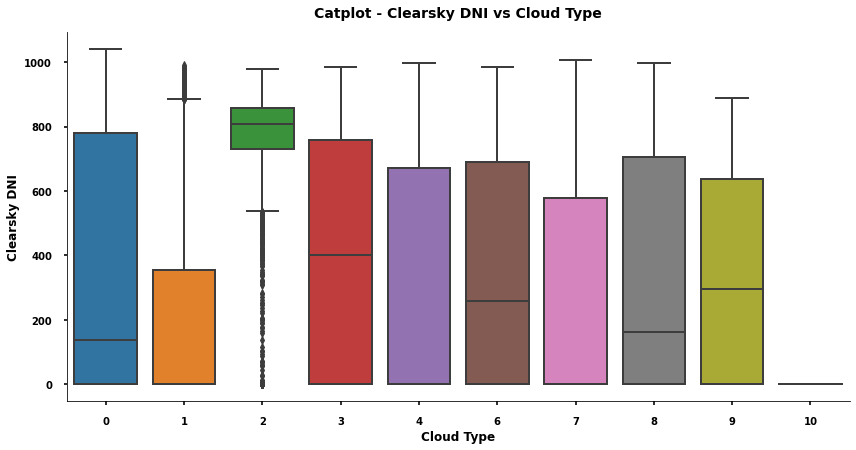

In [34]:
sns.catplot(y='Clearsky DNI', x='Cloud Type', kind="box", data=train, height=6, aspect=2)
plt.title('Catplot - Clearsky DNI vs Cloud Type', pad=15);

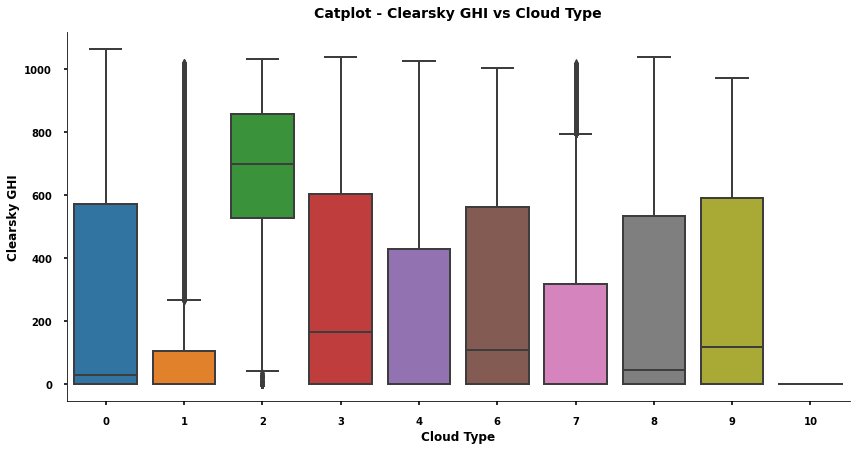

In [35]:
sns.catplot(y='Clearsky GHI', x='Cloud Type', kind="box", data=train, height=6, aspect=2)
plt.title('Catplot - Clearsky GHI vs Cloud Type', pad=15);

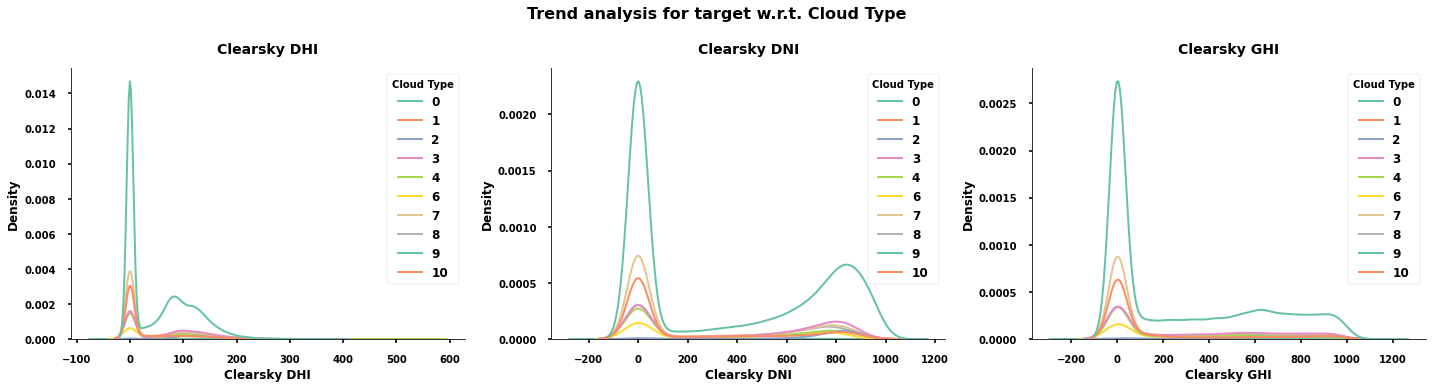

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.kdeplot(x='Clearsky DHI', hue='Cloud Type', data=train, palette='Set2', ax=ax[0], warn_singular=False)
sns.kdeplot(x='Clearsky DNI', hue='Cloud Type', data=train, palette='Set2', ax=ax[1], warn_singular=False)
sns.kdeplot(x='Clearsky GHI', hue='Cloud Type', data=train, palette='Set2', ax=ax[2], warn_singular=False)
ax[0].set_title('Clearsky DHI', pad=15)
ax[1].set_title('Clearsky DNI', pad=15)
ax[2].set_title('Clearsky GHI', pad=15)
fig.tight_layout()
plt.suptitle("Trend analysis for target w.r.t. Cloud Type",
             y=1.07, fontweight='bold');

In [37]:
train[train['Cloud Type']==10][['Clearsky DHI','Clearsky DNI','Clearsky GHI']].value_counts()

Clearsky DHI  Clearsky DNI  Clearsky GHI
0             0             0               1
dtype: int64

In [38]:
train['Cloud Type'].value_counts()

0     82788
7     23163
3     16255
1     15698
8     14276
4     11738
6      7902
2      3018
9       457
10        1
Name: Cloud Type, dtype: int64

In [39]:
test['Cloud Type'].value_counts()

0    9339
7    4044
3    1629
4     858
6     768
8     661
2     133
9      88
Name: Cloud Type, dtype: int64

In [40]:
set(train['Cloud Type']) - set(test['Cloud Type'])

{1, 10}

### Dew Point

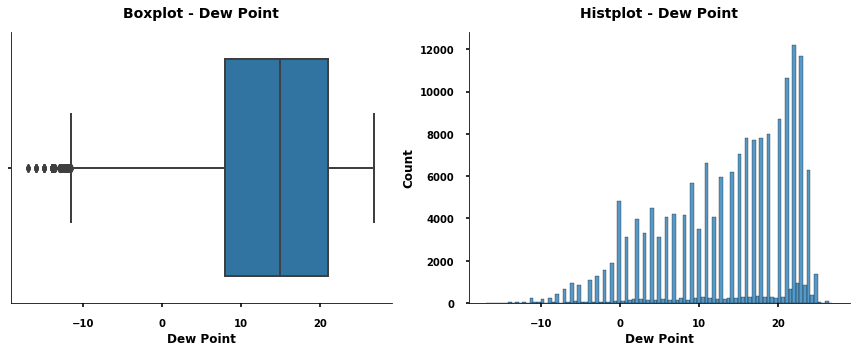

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x='Dew Point', data=train, ax=ax[0])
sns.histplot(x='Dew Point', data=train, ax=ax[1])
ax[0].set_title(f"Boxplot - Dew Point", pad=15)
ax[1].set_title(f"Histplot - Dew Point", pad=15)
fig.tight_layout();

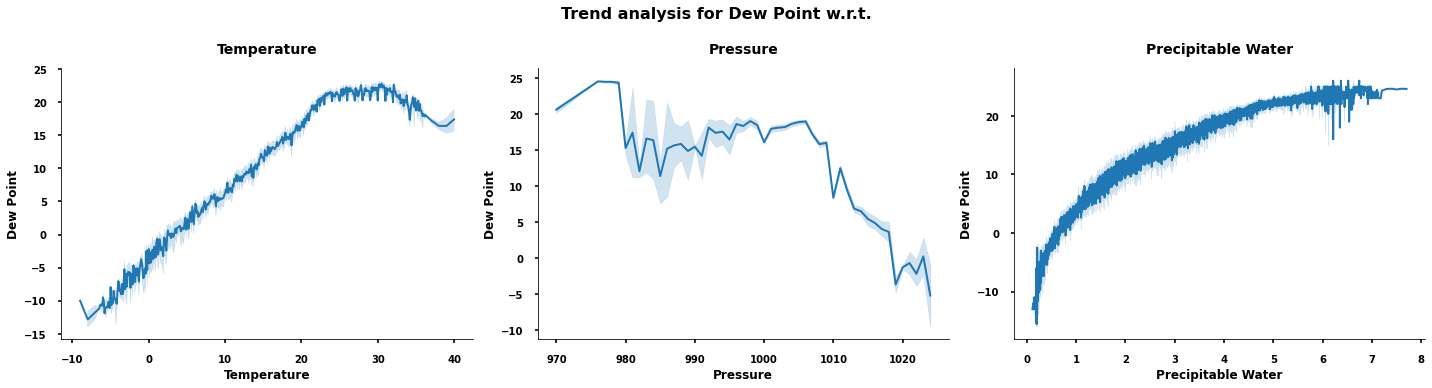

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.lineplot(x='Temperature', y='Dew Point', data=train, ax=ax[0])
sns.lineplot(x='Pressure', y='Dew Point', data=train, ax=ax[1])
sns.lineplot(x='Precipitable Water', y='Dew Point', data=train, ax=ax[2])
ax[0].set_title('Temperature', pad=15)
ax[1].set_title('Pressure', pad=15)
ax[2].set_title('Precipitable Water', pad=15)
fig.tight_layout()
plt.suptitle("Trend analysis for Dew Point w.r.t.",
             y=1.07, fontweight='bold');

### Temperature

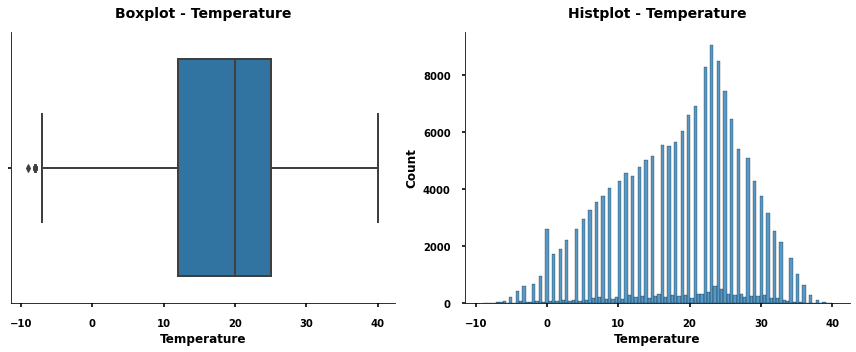

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x='Temperature', data=train, ax=ax[0])
sns.histplot(x='Temperature', data=train, ax=ax[1])
ax[0].set_title(f"Boxplot - Temperature", pad=15)
ax[1].set_title(f"Histplot - Temperature", pad=15)
fig.tight_layout();

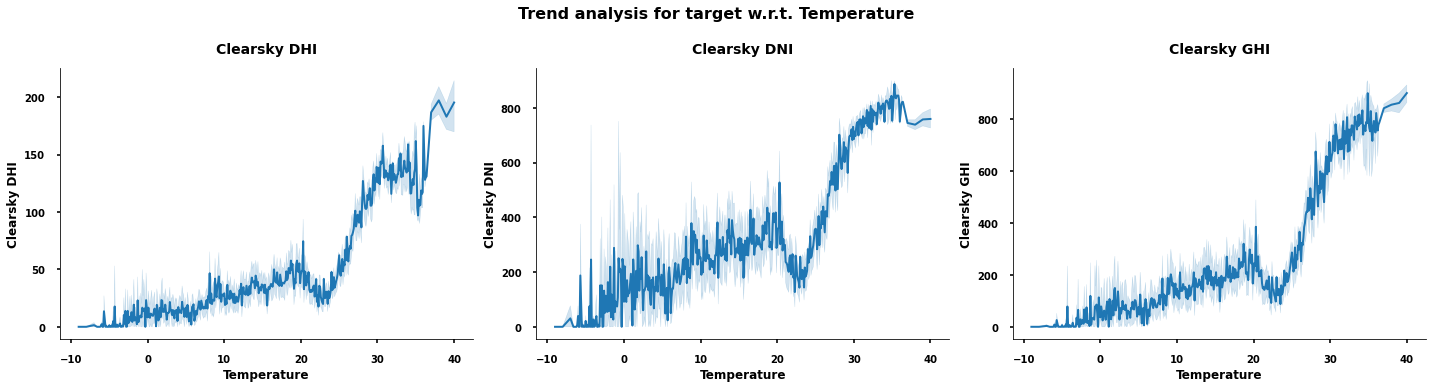

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.lineplot(x='Temperature', y='Clearsky DHI', data=train, ax=ax[0])
sns.lineplot(x='Temperature', y='Clearsky DNI', data=train, ax=ax[1])
sns.lineplot(x='Temperature', y='Clearsky GHI', data=train, ax=ax[2])
ax[0].set_title('Clearsky DHI', pad=15)
ax[1].set_title('Clearsky DNI', pad=15)
ax[2].set_title('Clearsky GHI', pad=15)
fig.tight_layout()
plt.suptitle("Trend analysis for target w.r.t. Temperature",
             y=1.07, fontweight='bold');

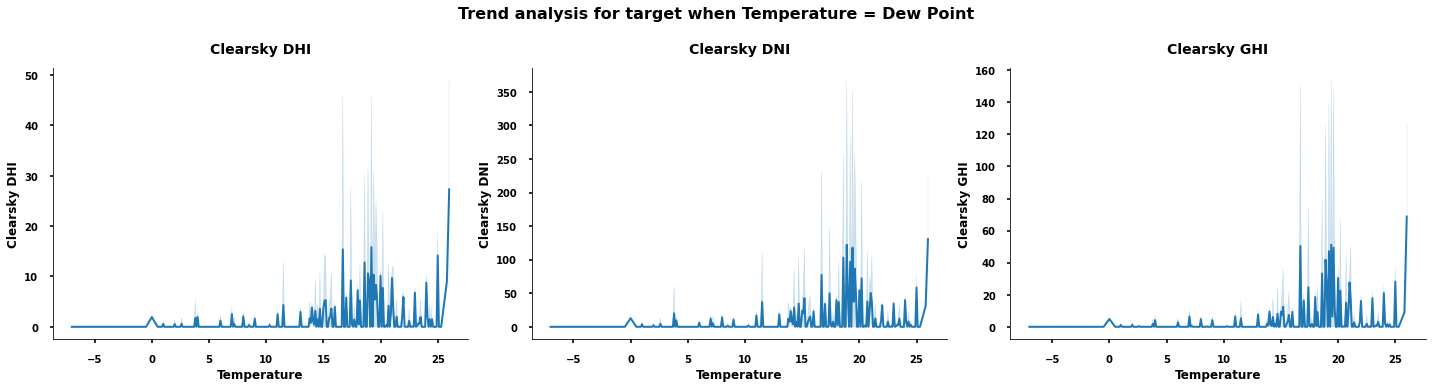

In [45]:
df = train[train['Temperature']==train['Dew Point']].copy()

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.lineplot(x='Temperature', y='Clearsky DHI', data=df, ax=ax[0])
sns.lineplot(x='Temperature', y='Clearsky DNI', data=df, ax=ax[1])
sns.lineplot(x='Temperature', y='Clearsky GHI', data=df, ax=ax[2])
ax[0].set_title('Clearsky DHI', pad=15)
ax[1].set_title('Clearsky DNI', pad=15)
ax[2].set_title('Clearsky GHI', pad=15)
fig.tight_layout()
plt.suptitle("Trend analysis for target when Temperature = Dew Point",
             y=1.07, fontweight='bold');

In [46]:
df[df['Temperature']<0]\
    .groupby(['Temperature','Clearsky DHI','Clearsky DNI','Clearsky GHI'])\
    .agg({'Clearsky DHI':'count','Clearsky DNI':'count','Clearsky GHI':'count'})

,,,,Clearsky DHI,Clearsky DNI,Clearsky GHI
Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,,,
-7.0,0,0,0,2,2,2
-4.0,0,0,0,4,4,4
-3.2,0,0,0,3,3,3
-3.0,0,0,0,43,43,43
-2.9,0,0,0,1,1,1
-2.7,0,0,0,1,1,1
-2.5,0,0,0,1,1,1
-2.3,0,0,0,1,1,1
-2.2,0,0,0,1,1,1


In [47]:
train['Temp vs Dew Point'] = train.apply(lambda x: 0 if x['Temperature']==x['Dew Point'] else 1 if x['Temperature']>x['Dew Point'] else 2, axis=1)

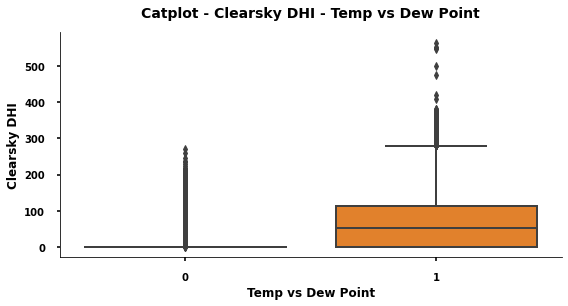

In [48]:
sns.catplot(y='Clearsky DHI', x='Temp vs Dew Point', kind="box", data=train, height=4, aspect=2)
plt.title('Catplot - Clearsky DHI - Temp vs Dew Point', pad=15);

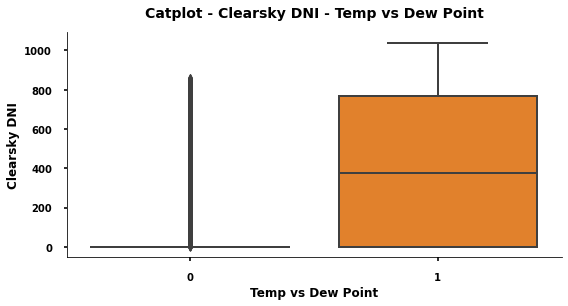

In [49]:
sns.catplot(y='Clearsky DNI', x='Temp vs Dew Point', kind="box", data=train, height=4, aspect=2)
plt.title('Catplot - Clearsky DNI - Temp vs Dew Point', pad=15);

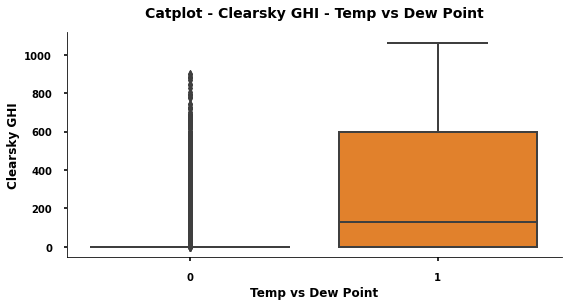

In [50]:
sns.catplot(y='Clearsky GHI', x='Temp vs Dew Point', kind="box", data=train, height=4, aspect=2)
plt.title('Catplot - Clearsky GHI - Temp vs Dew Point', pad=15);

### Pressure

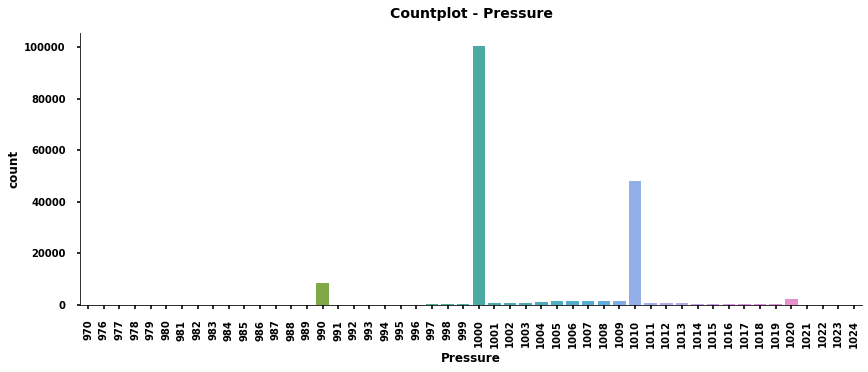

In [51]:
plt.figure(figsize=(14, 5))
sns.countplot(x='Pressure', data=train)
plt.xticks(rotation=90)
plt.title("Countplot - Pressure", pad=15);

In [52]:
set(train['Pressure']) - set(test['Pressure'])

{970, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 1024}

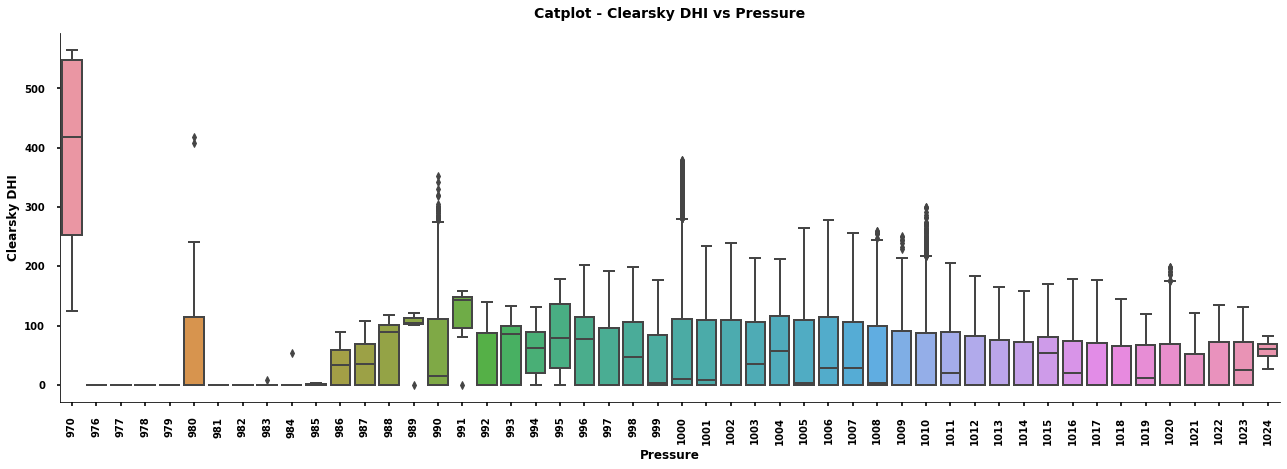

In [53]:
sns.catplot(y='Clearsky DHI', x='Pressure', kind="box", data=train, height=6, aspect=3)
plt.xticks(rotation=90)
plt.title('Catplot - Clearsky DHI vs Pressure', pad=15);

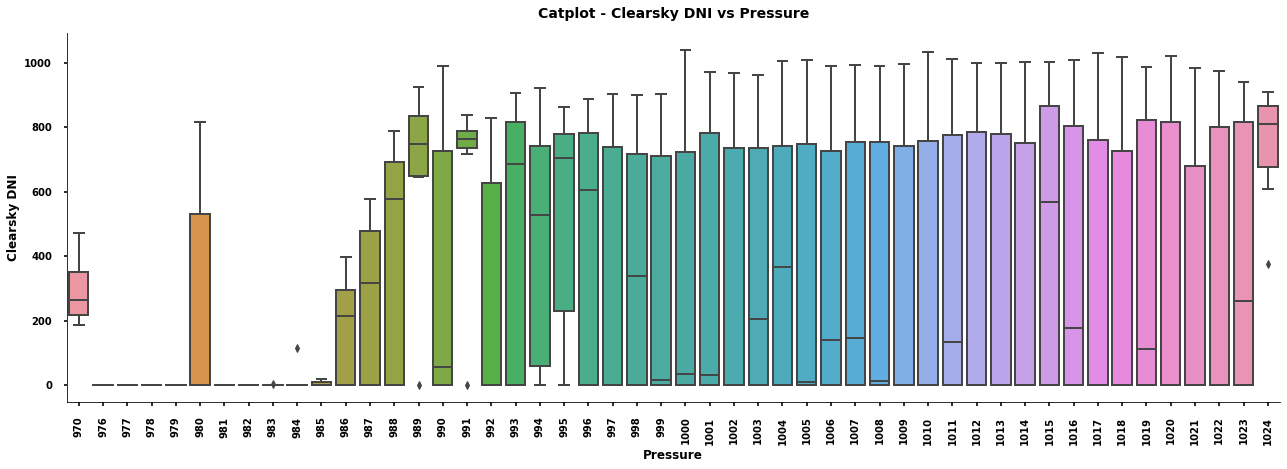

In [54]:
sns.catplot(y='Clearsky DNI', x='Pressure', kind="box", data=train, height=6, aspect=3)
plt.xticks(rotation=90)
plt.title('Catplot - Clearsky DNI vs Pressure', pad=15);

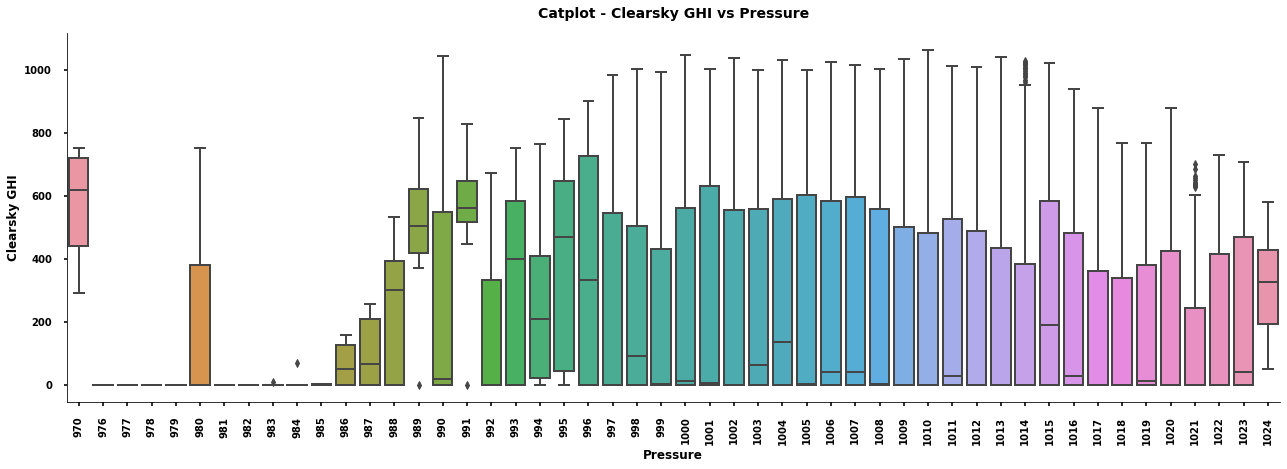

In [55]:
sns.catplot(y='Clearsky GHI', x='Pressure', kind="box", data=train, height=6, aspect=3)
plt.xticks(rotation=90)
plt.title('Catplot - Clearsky GHI vs Pressure', pad=15);

### Relative Humidity

In [56]:
train['Relative Humidity'] = train['Relative Humidity']/100.

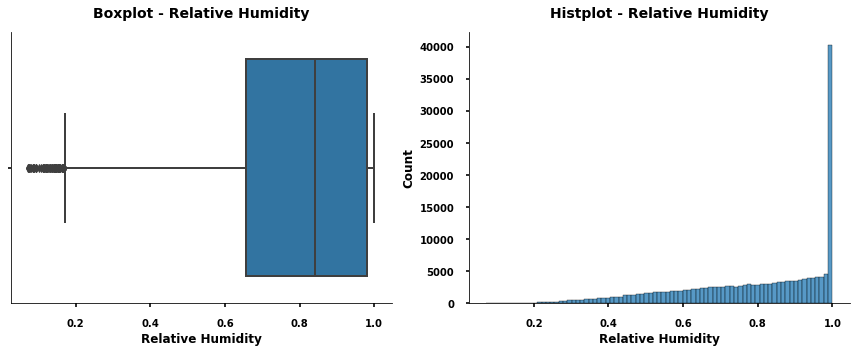

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x='Relative Humidity', data=train, ax=ax[0])
sns.histplot(x='Relative Humidity', data=train, ax=ax[1])
ax[0].set_title(f"Boxplot - Relative Humidity", pad=15)
ax[1].set_title(f"Histplot - Relative Humidity", pad=15)
fig.tight_layout();

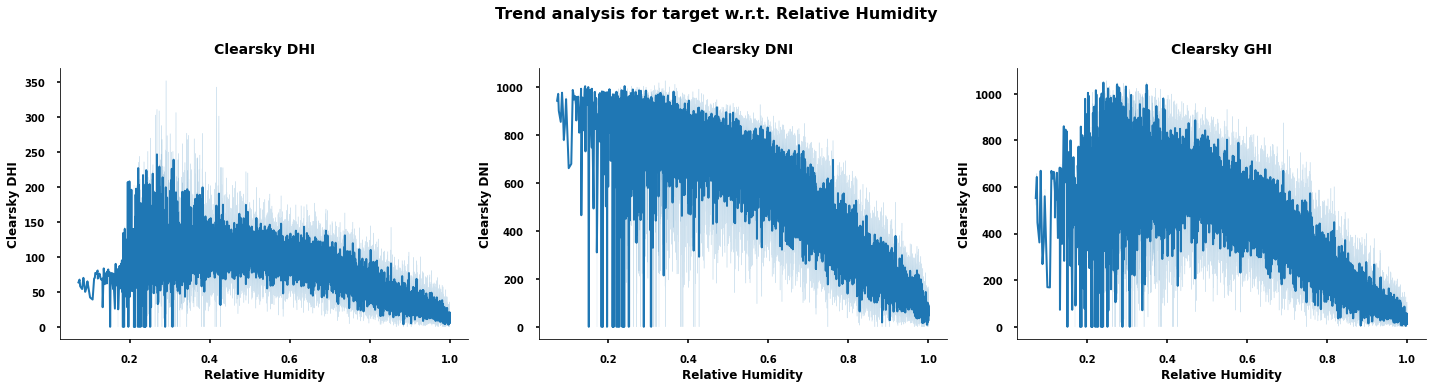

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.lineplot(x='Relative Humidity', y='Clearsky DHI', data=train, ax=ax[0])
sns.lineplot(x='Relative Humidity', y='Clearsky DNI', data=train, ax=ax[1])
sns.lineplot(x='Relative Humidity', y='Clearsky GHI', data=train, ax=ax[2])
ax[0].set_title('Clearsky DHI', pad=15)
ax[1].set_title('Clearsky DNI', pad=15)
ax[2].set_title('Clearsky GHI', pad=15)
fig.tight_layout()
plt.suptitle("Trend analysis for target w.r.t. Relative Humidity",
             y=1.07, fontweight='bold');

### Solar Zenith Angle

**Observation**

* All target variables are 0 for Solar Zenith Angle >= 93 degrees

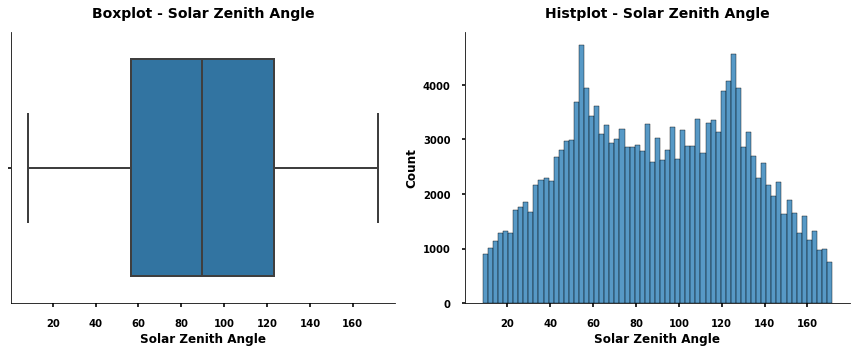

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x='Solar Zenith Angle', data=train, ax=ax[0])
sns.histplot(x='Solar Zenith Angle', data=train, ax=ax[1])
ax[0].set_title(f"Boxplot - Solar Zenith Angle", pad=15)
ax[1].set_title(f"Histplot - Solar Zenith Angle", pad=15)
fig.tight_layout();

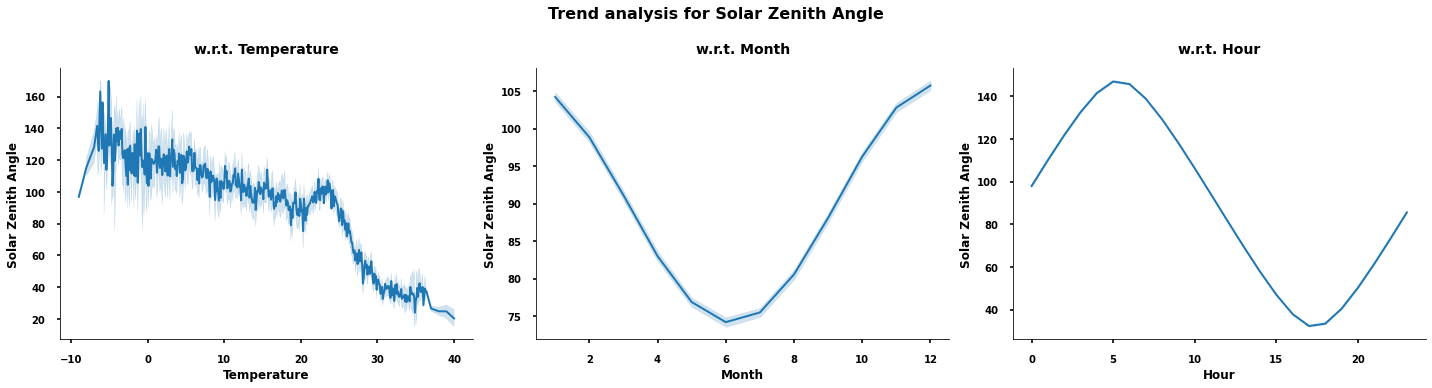

In [60]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.lineplot(x='Temperature', y='Solar Zenith Angle', data=train, ax=ax[0])
sns.lineplot(x='Month', y='Solar Zenith Angle', data=train, ax=ax[1])
sns.lineplot(x='Hour', y='Solar Zenith Angle', data=train, ax=ax[2])
ax[0].set_title('w.r.t. Temperature', pad=15)
ax[1].set_title('w.r.t. Month', pad=15)
ax[2].set_title('w.r.t. Hour', pad=15)
fig.tight_layout()
plt.suptitle("Trend analysis for Solar Zenith Angle",
             y=1.07, fontweight='bold');

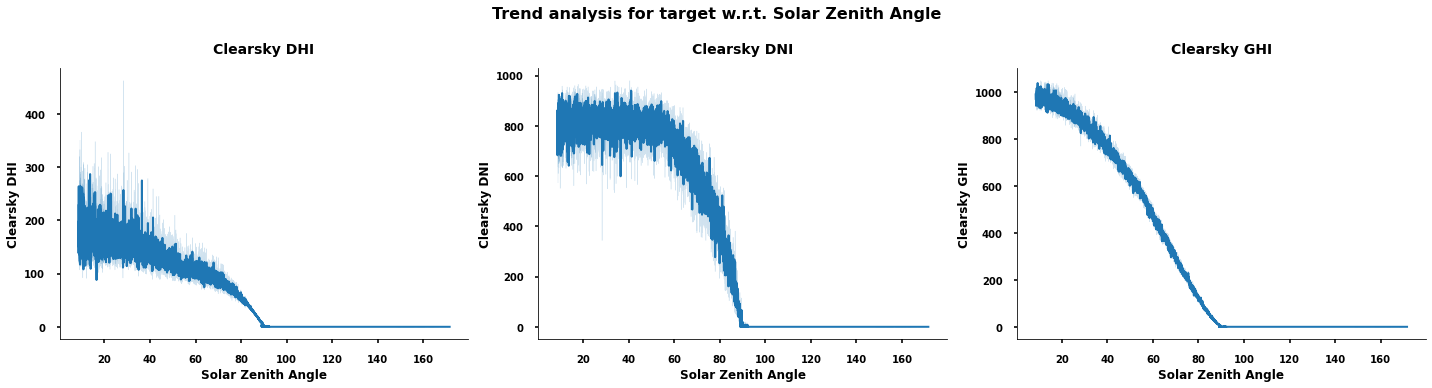

In [61]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.lineplot(x='Solar Zenith Angle', y='Clearsky DHI', data=train, ax=ax[0])
sns.lineplot(x='Solar Zenith Angle', y='Clearsky DNI', data=train, ax=ax[1])
sns.lineplot(x='Solar Zenith Angle', y='Clearsky GHI', data=train, ax=ax[2])
ax[0].set_title('Clearsky DHI', pad=15)
ax[1].set_title('Clearsky DNI', pad=15)
ax[2].set_title('Clearsky GHI', pad=15)
fig.tight_layout()
plt.suptitle("Trend analysis for target w.r.t. Solar Zenith Angle",
             y=1.07, fontweight='bold');

In [62]:
train[train['Solar Zenith Angle']>=93]['Clearsky DHI'].value_counts()

0    83733
Name: Clearsky DHI, dtype: int64

In [63]:
train[train['Solar Zenith Angle']>=93]['Clearsky DNI'].value_counts()

0    83733
Name: Clearsky DNI, dtype: int64

In [64]:
train[train['Solar Zenith Angle']>=93]['Clearsky GHI'].value_counts()

0    83733
Name: Clearsky GHI, dtype: int64

### Precipitable Water

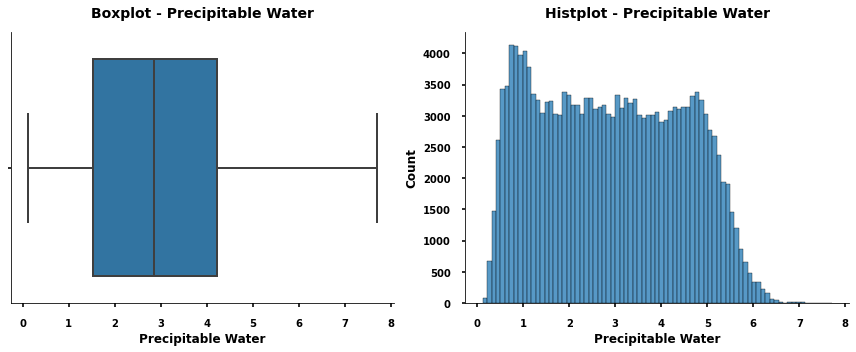

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x='Precipitable Water', data=train, ax=ax[0])
sns.histplot(x='Precipitable Water', data=train, ax=ax[1])
ax[0].set_title(f"Boxplot - Precipitable Water", pad=15)
ax[1].set_title(f"Histplot - Precipitable Water", pad=15)
fig.tight_layout();

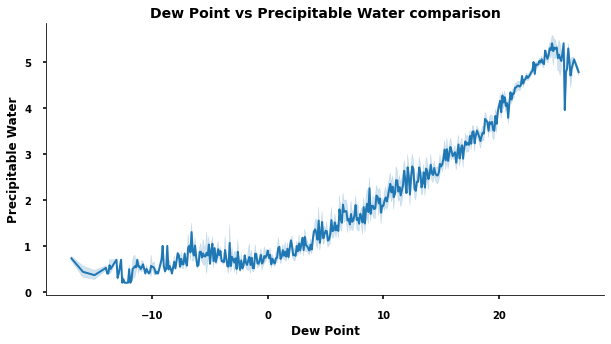

In [66]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='Dew Point', y='Precipitable Water', data=train)
plt.title("Dew Point vs Precipitable Water comparison");

### Wind Direction

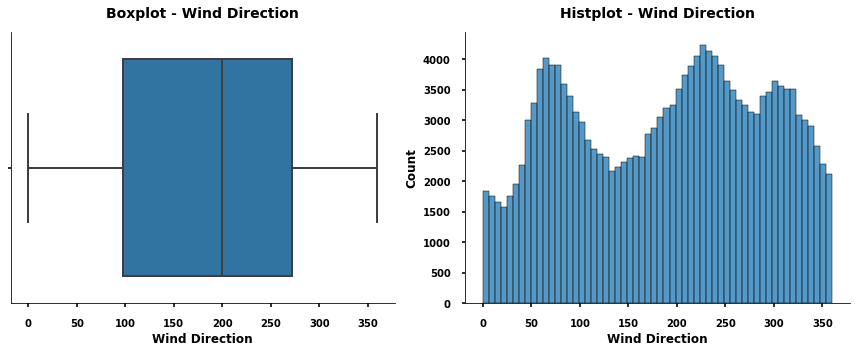

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x='Wind Direction', data=train, ax=ax[0])
sns.histplot(x='Wind Direction', data=train, ax=ax[1])
ax[0].set_title(f"Boxplot - Wind Direction", pad=15)
ax[1].set_title(f"Histplot - Wind Direction", pad=15)
fig.tight_layout();

In [68]:
train['Wind Direction Quad'] = train['Wind Direction'].apply(lambda x: 1 if x>=0 and x<=90 else 2 if x>90 and x<=180 else 3 if x>180 and x<=270 else 4)

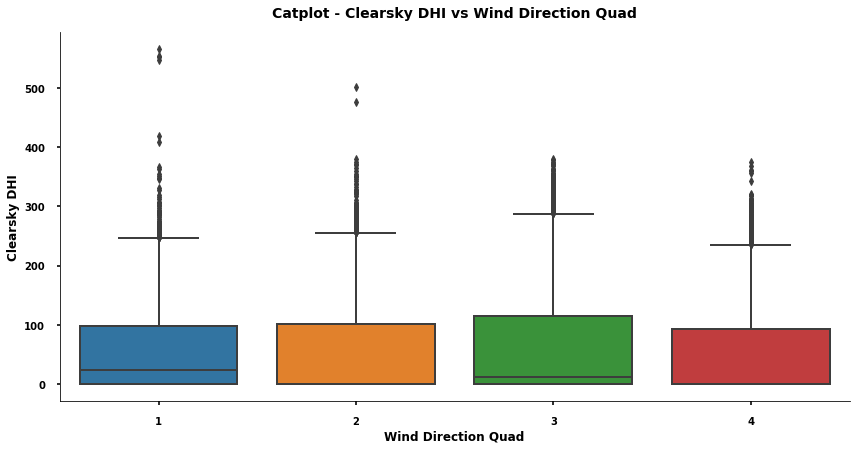

In [69]:
sns.catplot(y='Clearsky DHI', x='Wind Direction Quad', kind="box", data=train, height=6, aspect=2)
plt.title('Catplot - Clearsky DHI vs Wind Direction Quad', pad=15);

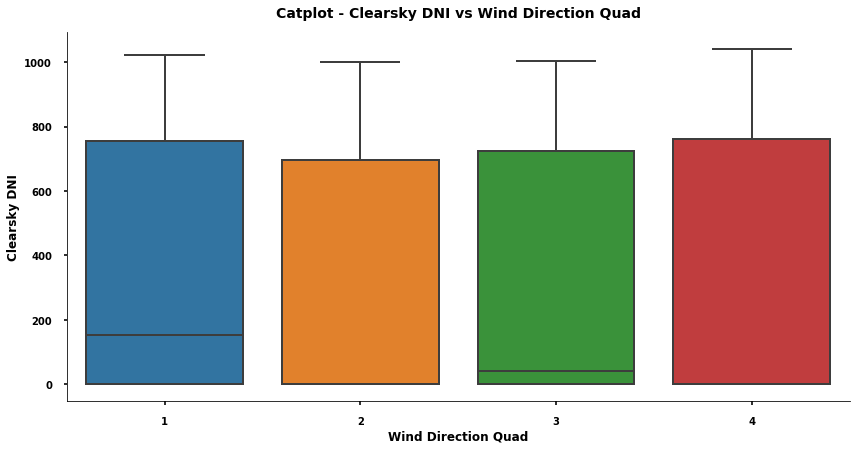

In [70]:
sns.catplot(y='Clearsky DNI', x='Wind Direction Quad', kind="box", data=train, height=6, aspect=2)
plt.title('Catplot - Clearsky DNI vs Wind Direction Quad', pad=15);

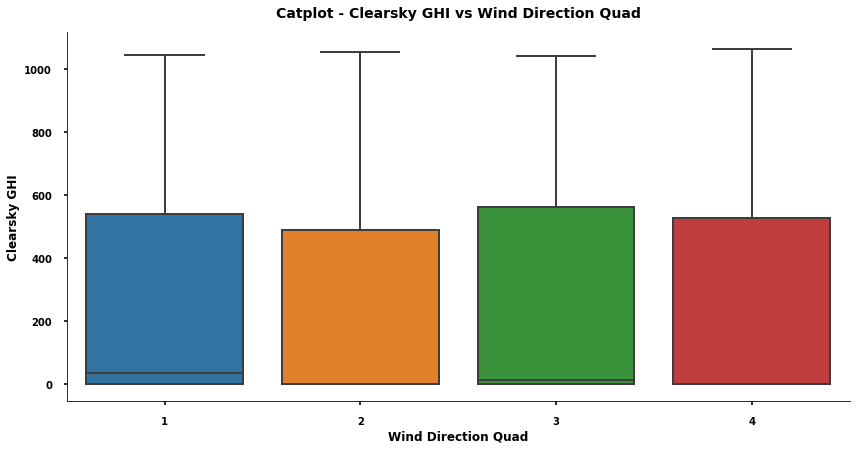

In [71]:
sns.catplot(y='Clearsky GHI', x='Wind Direction Quad', kind="box", data=train, height=6, aspect=2)
plt.title('Catplot - Clearsky GHI vs Wind Direction Quad', pad=15);

### Wind Speed

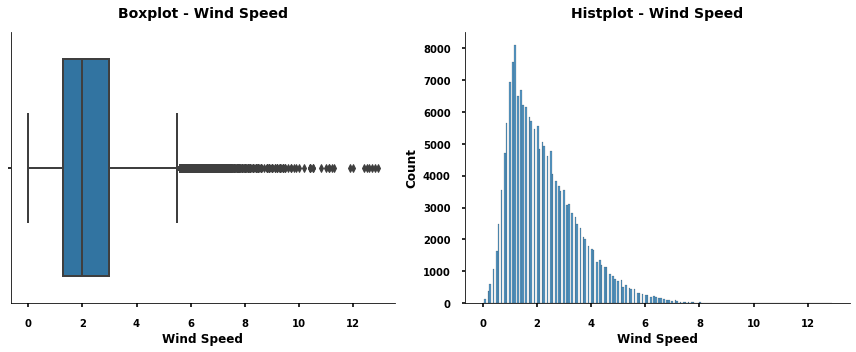

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x='Wind Speed', data=train, ax=ax[0])
sns.histplot(x='Wind Speed', data=train, ax=ax[1])
ax[0].set_title(f"Boxplot - Wind Speed", pad=15)
ax[1].set_title(f"Histplot - Wind Speed", pad=15)
fig.tight_layout();

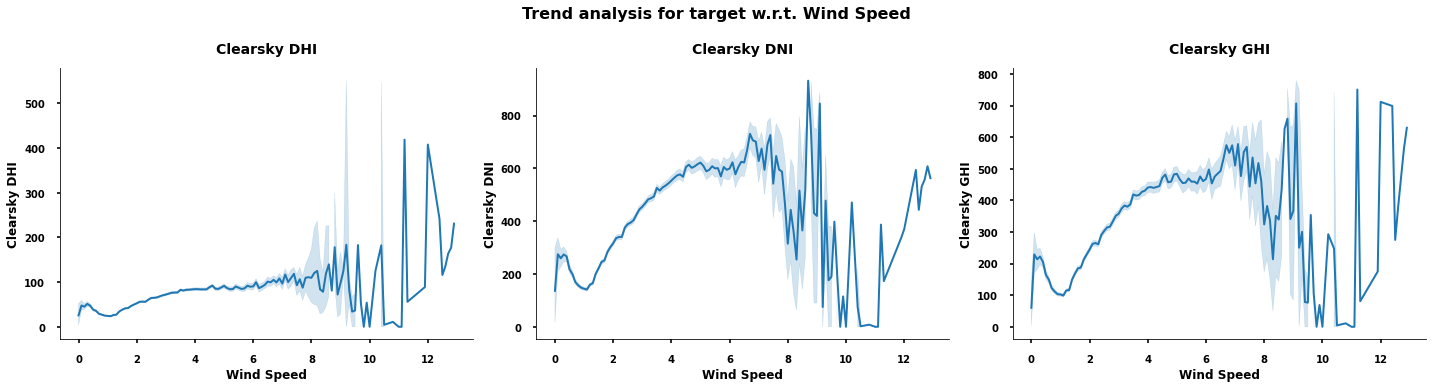

In [73]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.lineplot(x='Wind Speed', y='Clearsky DHI', data=train, ax=ax[0])
sns.lineplot(x='Wind Speed', y='Clearsky DNI', data=train, ax=ax[1])
sns.lineplot(x='Wind Speed', y='Clearsky GHI', data=train, ax=ax[2])
ax[0].set_title('Clearsky DHI', pad=15)
ax[1].set_title('Clearsky DNI', pad=15)
ax[2].set_title('Clearsky GHI', pad=15)
fig.tight_layout()
plt.suptitle("Trend analysis for target w.r.t. Wind Speed",
             y=1.07, fontweight='bold');

### Fill Flag

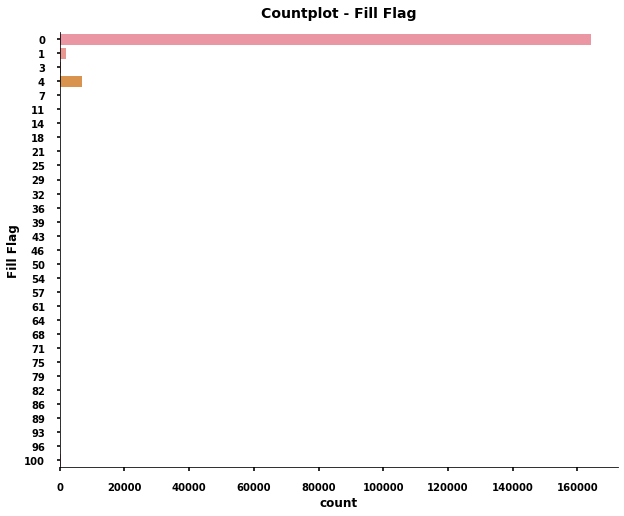

In [74]:
plt.figure(figsize=(10, 8))
sns.countplot(y='Fill Flag', data=train)
plt.title("Countplot - Fill Flag", pad=15);

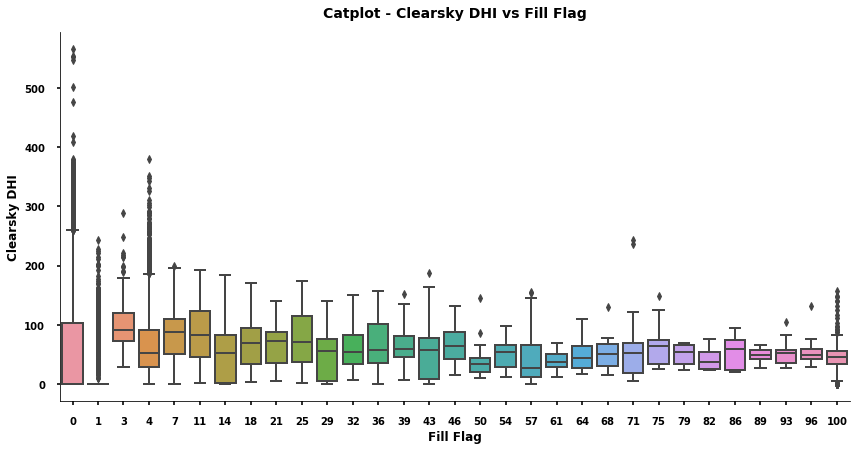

In [75]:
sns.catplot(y='Clearsky DHI', x='Fill Flag', kind="box", data=train, height=6, aspect=2)
plt.title('Catplot - Clearsky DHI vs Fill Flag', pad=15);

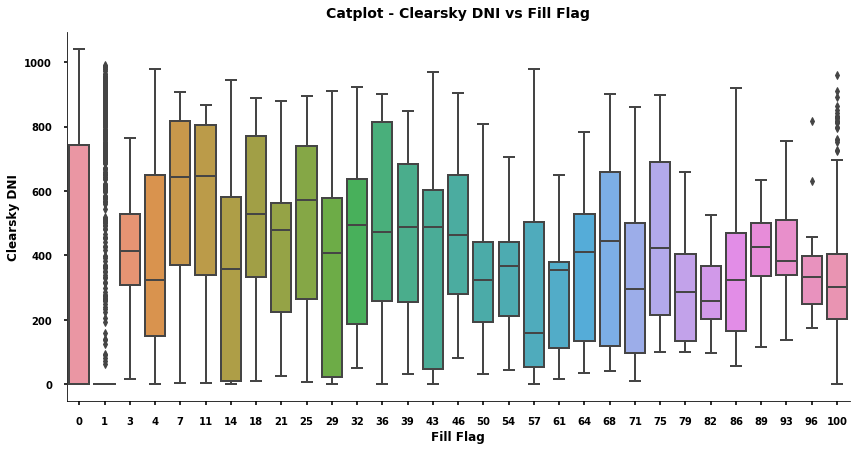

In [76]:
sns.catplot(y='Clearsky DNI', x='Fill Flag', kind="box", data=train, height=6, aspect=2)
plt.title('Catplot - Clearsky DNI vs Fill Flag', pad=15);

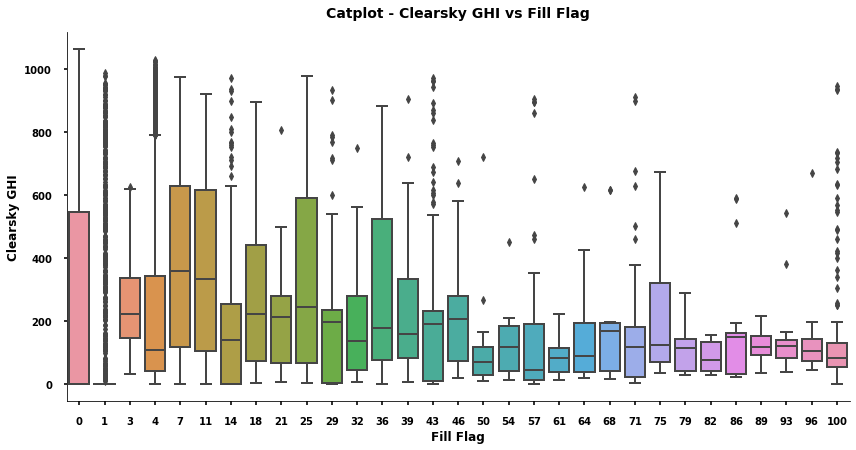

In [77]:
sns.catplot(y='Clearsky GHI', x='Fill Flag', kind="box", data=train, height=6, aspect=2)
plt.title('Catplot - Clearsky GHI vs Fill Flag', pad=15);

In [78]:
set(train['Fill Flag']) - set(test['Fill Flag'])

{1, 3}

## Feature Correlation

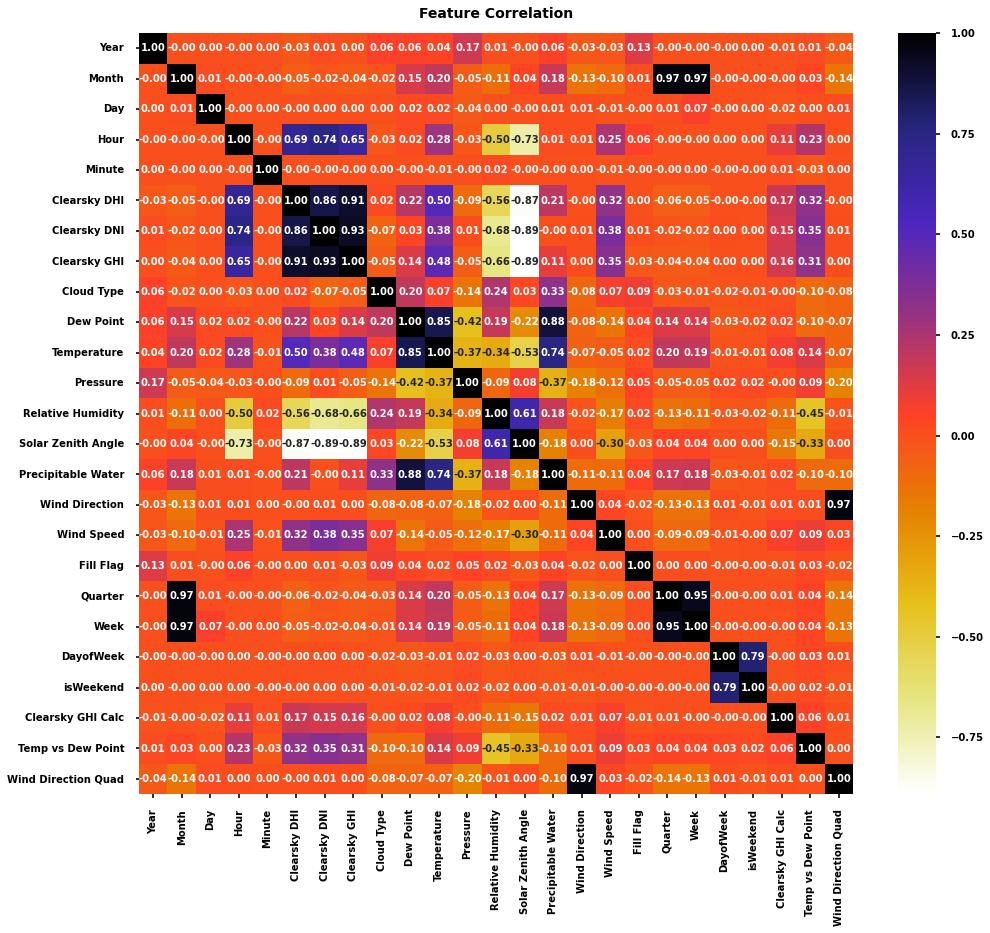

In [79]:
plt.figure(figsize=(16, 14))
sns.heatmap(train.corr(), annot=True, fmt='.2f', cmap="CMRmap_r")
plt.title("Feature Correlation", pad=15);